# Pollinator Detection – Starting Kit
---

Description of your challenge and instructions for challenge participants :

This notebook is the starting kit for the Pollinator Detection challenge. Its goal is to guide participants through the first steps of the project by demonstrating how to load the data, explore it, visualize examples, and build initial models using the provided tools.

The dataset used in this challenge consists of .h5 files, where each file contains a sequence of images and is associated with a binary label indicating the presence (1) or absence (0) of a pollinator. Throughout this notebook, each sequence is treated as a single data sample.

When running this notebook, the required data will be automatically downloaded if it is not already available locally.

This notebook is organized to progressively introduce the main components of the challenge:
- Data loading: how to access the dataset and configure memory usage or sampling size.
- Data exploration and visualization: how to inspect class distribution, visualize image sequences, and gain intuition about the data.
- Baseline modeling: simple examples illustrating how one might begin training and evaluating a model.
- Evaluation: an introduction to some appropriate metrics.

This notebook does not aim to provide a final or optimal solution. Instead, it serves as a reference implementation and learning tool to help participants understand the challenge and confidently begin developing their own approaches.

---

`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/M1-AI-Challenge-Class-2025-26.git
    # move to the starting kit folder
    %cd M1-AI-Challenge-Class-2025-26/Starting_Kit/

# 0 - Imports & Settings

In [24]:
import os
import datetime
import h5py
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# 1 - Data

## Description

This class provides an automated pipeline for handling the challenge datasets. It automatically downloads the train and test set if they are not already present. It then load a fraction of the data, using a stratified slicing to keep the dataset intrisic proportion of both classes in the train and test set. The stratified slicing ensures that even when loading a small fraction of the data for fast prototyping, the rare "Visitor" class ratio (approx. 2.7%) is perfectly preserved. It offers a flexible memory management toggle, allowing users to choose between high-speed sequential RAM loading or memory-efficient direct-disk access.

## How to use it

Initialize: Create an instance by specifying your local data directory.

Load: Call load_data() with two key parameters:

sample_fraction: Set between 0.0 and 1.0 (e.g., 0.02 to load 2% for quick testing).

load_to_memory: Set to True for maximum speed (requires ~3GB RAM) or False if working on a machine with limited memory

In [ ]:
class Data:
    def __init__(self, data_dir="data"):
        self.data_dir = data_dir
        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None
        
    def download_data(self):
        """Downloads files from Google Drive if not present."""
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)

        files = {
            "train_data.h5": "1IaurPYK0lNMACw_9RohSJ5TwOgO1dhXt",
            "train_labels.npy": "1fStRNtVMhw7bWV6vbsVAaTprk5S0Ym1A",
            "test_data.h5": "1HMNdBhMPO01alf4f5oUZz5vgaDxR_VrX",
            "test_labels.npy": "11_uKvuMOAkH7HaOCZzKAA9FPJV03Vtfo"
        }

        for name, file_id in files.items():
            path = os.path.join(self.data_dir, name)
            if not os.path.exists(path) or os.path.getsize(path) < 1000:
                print(f"[*] Downloading {name}...")
                url = f'https://drive.google.com/uc?id={file_id}'
                gdown.download(url, path, quiet=False)
            else:
                print(f"[OK] {name} is ready.")

    def load_data(self, sample_fraction=1.0, load_to_memory=False):
        """
        Loads the data. If sample_fraction < 1.0, it performs a stratified 
        sampling to keep only X% of the dataset.
        """
        self.download_data()
        print(f"[*] Loading data (fraction={sample_fraction*100}%)...")

        # --- 1. TRAIN SET ---
        y_train_full = np.load(os.path.join(self.data_dir, "train_labels.npy"), allow_pickle=True)
        
        idx_tr = None
        if sample_fraction < 1.0:
            # We use train_size to be explicit: keep 10%
            idx_tr, _ = train_test_split(
                np.arange(len(y_train_full)), 
                train_size=sample_fraction, 
                stratify=y_train_full, 
                random_state=42
            )
            idx_tr = sorted(idx_tr)
            self.y_train = y_train_full[idx_tr]
        else:
            self.y_train = y_train_full

        with h5py.File(os.path.join(self.data_dir, "train_data.h5"), "r") as f:
            print(f"[*] Loading training images...")
            # If load_to_memory is True, we load all then slice. 
            # If False, we slice directly from the disk (efficient but slower).
            if load_to_memory:
                self.X_train = f["images"][:][idx_tr] if idx_tr is not None else f["images"][:]
            else:
                self.X_train = f["images"][idx_tr] if idx_tr is not None else f["images"][:]

        # --- 2. TEST SET ---
        y_test_full = np.load(os.path.join(self.data_dir, "test_labels.npy"), allow_pickle=True)
        
        idx_te = None
        if sample_fraction < 1.0:
            idx_te, _ = train_test_split(
                np.arange(len(y_test_full)), 
                train_size=sample_fraction, 
                stratify=y_test_full, 
                random_state=42
            )
            idx_te = sorted(idx_te)
            self.y_test = y_test_full[idx_te]
        else:
            self.y_test = y_test_full

        with h5py.File(os.path.join(self.data_dir, "test_data.h5"), "r") as f:
            print(f"[*] Loading test images...")
            if load_to_memory:
                self.X_test = f["images"][:][idx_te] if idx_te is not None else f["images"][:]
            else:
                self.X_test = f["images"][idx_te] if idx_te is not None else f["images"][:]

        print(f"[✔] Loaded {len(self.y_train)} train and {len(self.y_test)} test samples.")

In [5]:
data_manager = Data(data_dir="data")

# sample_fraction=0.1 for quick testing (load 10% of data)
# Loading with load_to_memory=True requires ~3-4GB of free RAM (faster)
# Loading with load_to_memory=False is slower but more memory efficient
data_manager.load_data(sample_fraction=0.1, load_to_memory=True)

[OK] train_data.h5 is ready.
[OK] train_labels.npy is ready.
[OK] test_data.h5 is ready.
[OK] test_labels.npy is ready.
[*] Loading data (fraction=10.0%)...
[*] Loading training images...
[*] Loading training metadata...
[*] Loading test images...
[*] Loading test metadata...
[✔] Loaded 3041 train and 1013 test samples.


# 2 - Visualization

This section allows for an exploratory analysis of the dataset to understand the class distribution and visually inspect the samples.

What we have implemented:
Class Distribution Analysis: A bar chart to visualize the significant imbalance between the "No Visitor" (0) and "Visitor" (1) classes. This highlights why standard accuracy is misleading and why we prioritize Balanced Accuracy and F1-Score later in this notebook.

Sample Inspection: A grid display of random images from each class.

Dimensionality Reduction (PCA): A 2D projection of the raw pixels. By balancing the classes for this specific visualization, we can see if "Visitor" images cluster together or if they are indistinguishable from "No Visitor" images in the raw pixel space.

In [6]:
class Visualize:
    def __init__(self, data_manager):
        self.data = data_manager

    def plot_class_distribution(self):
        """Plots the count of each class in the training set."""
        print("[*] Plotting class distribution...")
        plt.figure(figsize=(10, 5))
        # Map 0 to 'No Visitor' and 1 to 'Visitor' for readability
        names = ["Visitor" if l == 1 else "No Visitor" for l in self.data.y_train]
        
        sns.countplot(x=names, palette="magma", hue=names, legend=False)
        plt.title("Class Distribution (0: No Visitor vs 1: Visitor)")
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.show()

    def plot_pca(self, n_per_class=500):
        """Performs PCA on flattened raw pixels for a balanced subset."""
        print(f"[*] Balancing data for PCA: selecting {n_per_class} samples per class...")
        
        # Get indices for each class
        idx_0 = np.where(self.data.y_train == 0)[0]
        idx_1 = np.where(self.data.y_train == 1)[0]
        
        # Randomly sample to balance the visualization
        selected_0 = np.random.choice(idx_0, min(n_per_class, len(idx_0)), replace=False)
        selected_1 = np.random.choice(idx_1, min(n_per_class, len(idx_1)), replace=False)
        
        indices = np.concatenate([selected_0, selected_1])
        
        # Flatten images: (N, H, W, C) -> (N, H*W*C)
        X_subset = self.data.X_train[indices].reshape(len(indices), -1)
        y_subset = self.data.y_train[indices]
        
        print(f"[*] Computing PCA on {len(indices)} samples...")
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_subset)
        
        plt.figure(figsize=(10, 7))
        for label_val, color, label_name in [(0, 'steelblue', 'No Visitor'), (1, 'orange', 'Visitor')]:
            mask = y_subset == label_val
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                        c=color, label=label_name, alpha=0.6, edgecolors='w')
        
        plt.legend()
        plt.title("PCA Projection of Raw Pixels")
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()

    def show_images(self, n_images=3):
        """Displays sample images from each class."""
        print(f"[*] Displaying {n_images} random samples per class...")
        fig, axes = plt.subplots(2, n_images, figsize=(15, 8))
        
        for class_id in [0, 1]:
            idx_list = np.where(self.data.y_train == class_id)[0]
            np.random.seed(69)
            selected_idx = np.random.choice(idx_list, n_images, replace=False)
            
            for i, idx in enumerate(selected_idx):
                ax = axes[class_id, i]
                ax.imshow(self.data.X_train[idx])
                label_str = "Visitor" if class_id == 1 else "No Visitor"
                ax.set_title(f"Class {class_id}: {label_str}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    def run_all(self):
        """Runs all visualization functions."""
        self.plot_class_distribution()
        self.show_images()
        self.plot_pca()

[*] Plotting class distribution...


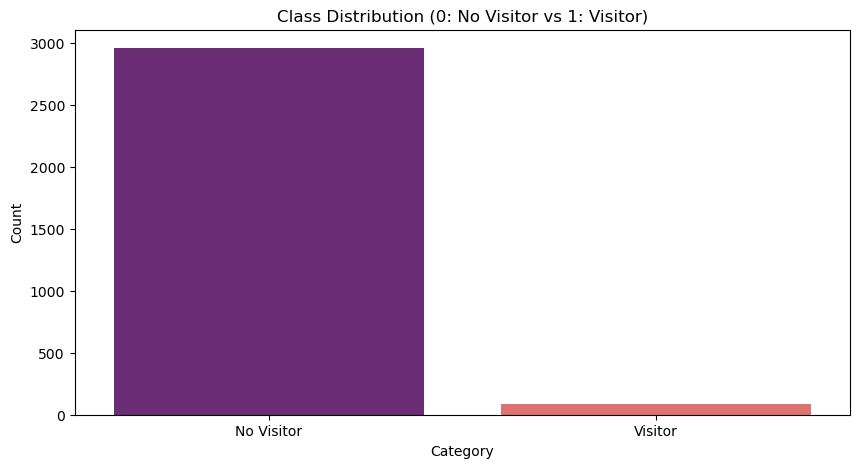

[*] Displaying 3 random samples per class...


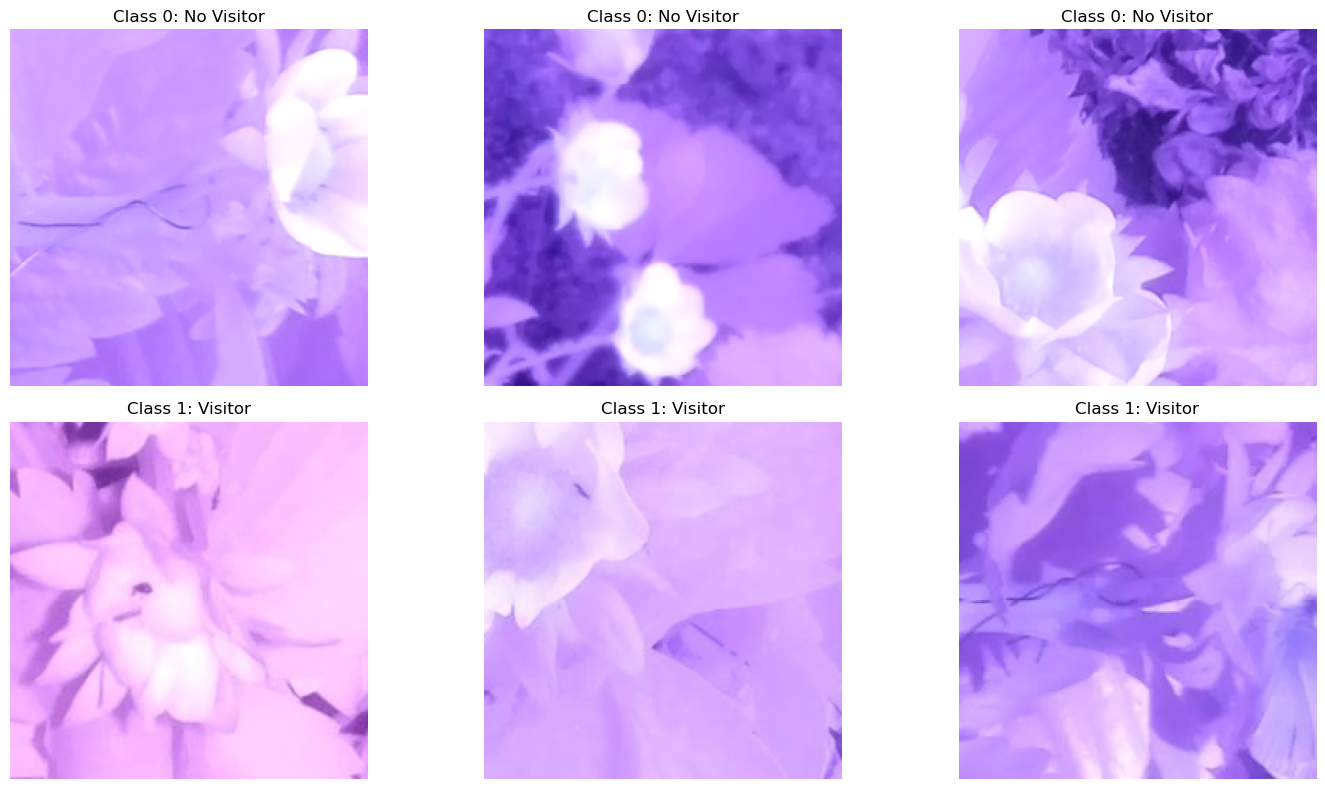

[*] Balancing data for PCA: selecting 500 samples per class...
[*] Computing PCA on 583 samples...


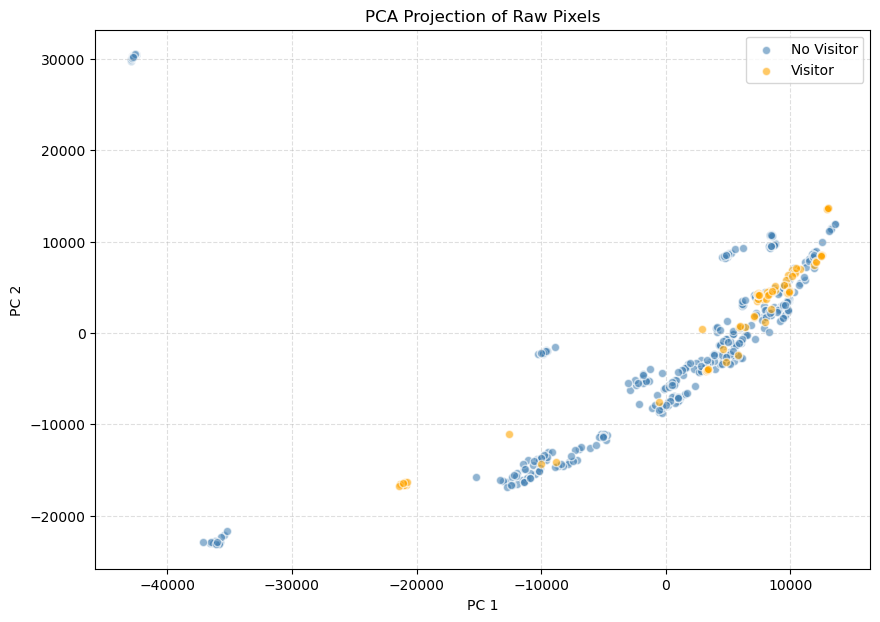

In [7]:
viz = Visualize(data_manager)
viz.run_all()

We notice a high imbalance between classes, with over 97% "No Visitors" and less than 3% "Visitors". This problem will have to be adressed later in the training and scoring.

The PCA shows that both classes overlap, probably due to the background of the images (the flowers) being predominant. We see a few cluster due to different colors on the images.

# 3 - Training

In this section, we train a Random Forest Classifier as our baseline model to detect pollinators in image data. This model was chosen for its robustness and ability to handle the high dimensionality of raw pixel data without requiring complex preprocessing.

## Why Random Forest?

Parallel Processing: We use n_jobs=-1 to build trees in parallel across all available CPU cores, significantly speeding up training on large image vectors.

Handling Imbalance: By setting class_weight='balanced', the model automatically adjusts for our minority "Visitor" class (~2.7%), ensuring the trees prioritize the rare insect samples.

Feature Robustness: Random Forests are less prone to overfitting than individual decision trees and work effectively as a first-pass model before moving to better models.

In [8]:
class Train:
    def __init__(self, data_manager: Data):
        """
        Initializes the training pipeline using the pre-sampled data 
        available in the data_manager.
        """
        self.data = data_manager
        self.model = RandomForestClassifier(
            n_estimators=100, 
            class_weight='balanced', 
            random_state=42,
            n_jobs=-1 
        )
        self.X_train_flat = None
        self.y_train = None

    def prepare_data(self):
        """
        Flattens the images already loaded in data_manager.
        No new splitting is needed as data_manager already handled sampling.
        """
        print(f"[*] Flattening {len(self.data.X_train)} images...")
        
        # Flatten: (N, 224, 224, 3) -> (N, 150528)
        self.X_train_flat = self.data.X_train.reshape(len(self.data.X_train), -1)
        self.y_train = self.data.y_train
        
        print(f"[OK] Ready to train on {self.X_train_flat.shape[0]} samples.")

    def train(self):
        """
        Trains the Random Forest model.
        """
        if self.X_train_flat is None:
            self.prepare_data()
            
        print("[*] Starting Random Forest training...")
        self.model.fit(self.X_train_flat, self.y_train)
        print("[✔] Model trained successfully!")

In [9]:
trainer = Train(data_manager)
trainer.train()

[*] Flattening 3041 images...
[OK] Ready to train on 3041 samples.
[*] Starting Random Forest training...
[✔] Model trained successfully!


# 4 - Scoring

This section evaluates the trained model on unseen data using the X_test set from the data_manager. Testing on separate data is essential to verify the model's generalization capabilities and check for overfitting.

## Methodology:
Data Flattening: Since the Random Forest model cannot process 4D image arrays (height, width, channels), each test image is flattened into a 1D pixel vector.

Metric Selection: Standard accuracy is misleading due to the high class imbalance (~2.7% visitors). We use the following metrics instead:

Balanced Accuracy: Calculates the average recall for each class, giving equal importance to both majority and minority classes.

F1-Score: The harmonic mean of Precision and Recall, providing a balanced view of the model's performance specifically on the "Visitor" class.

Confusion Matrix: A visual tool to identify the nature of errors, such as False Positives (misidentifying a flower as having an insect) or False Negatives (missing an actual insect).

In an imbalanced dataset, Balanced Accuracy prevents the model from appearing successful by simply guessing the majority class, as it calculates the average performance across both classes independently. Meanwhile, the F1-Score provides a single measure of reliability by balancing the trade-off between avoiding false alarms (Precision) and ensuring no actual visitors are missed (Recall).

In [18]:
class Score:
    def __init__(self):
        self.results = {}
        self.cm = None

    def compute_score(self, data_manager, trainer):
        """
        Computes predictions and scores using the trainer's model and validation data.
        """
        print(f"[*] Flattening {len(data_manager.X_test)} test images...")
        X_test_flat = data_manager.X_test.reshape(len(data_manager.X_test), -1)
        
        # 1. Compute y_pred using flattened data
        y_pred = trainer.model.predict(X_test_flat)
        y_true = data_manager.y_test
        
        # 2. Confusion Matrix      
        self.cm = confusion_matrix(y_true, y_pred)
        
        # 3. Metrics Calculation
        self.results['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
        self.results['F1 Score'] = f1_score(y_true, y_pred, pos_label=1)
        
        # 4. Automatic Visualization
        self._display_results()
        
        return self.results

    def _display_results(self):
        """Displays the metrics table and the confusion matrix."""
        print("="*40)
        print(f"{'EVALUATION METRICS':^40}")
        print("="*40)
        for metric, value in self.results.items():
            print(f"{metric:<20} : {value:.4f}")
        print("="*40)

        print("\n[*] Plotting Confusion Matrix...")
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=["No Visitor", "Visitor"])
        disp.plot(cmap='Blues', ax=ax, values_format='d')
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.show()

[*] Flattening 1013 test images...
           EVALUATION METRICS           
Balanced Accuracy    : 0.8036
F1 Score             : 0.7556

[*] Plotting Confusion Matrix...


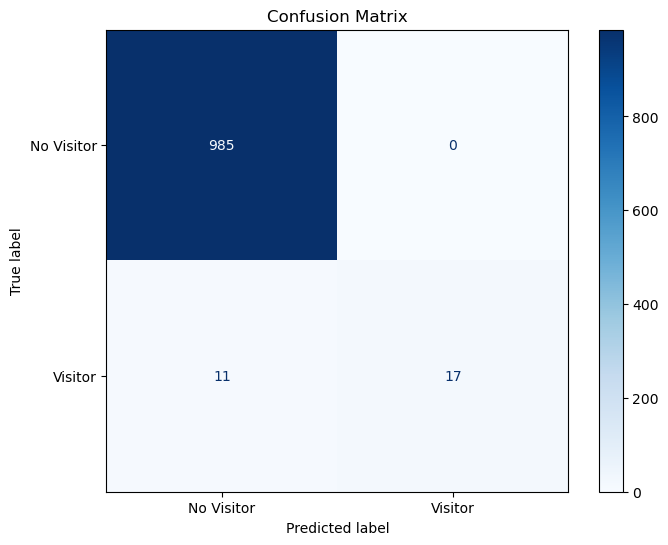

{'Balanced Accuracy': 0.8035714285714286, 'F1 Score': 0.7555555555555555}

In [20]:
score = Score()
score.compute_score(data_manager, trainer)

# 5 - (Optional) Prepare submission for Codabench

***

In this section you should prepare a zip of the trained model (if your competition is a code submission competition) or zip of the predictions (if your competition is a result submission competition). 

***

In [21]:
import os
import zipfile
import joblib
import pandas as pd

class Submission:
    def __init__(self, submission_dir, zip_file_name):
        self.submission_dir = submission_dir
        self.zip_file_name = zip_file_name
        # Create directory if it doesn't exist
        os.makedirs(self.submission_dir, exist_ok=True)

    def save_code(self, model):
        """
        Saves the trained model object to the submission directory.
        """
        model_path = os.path.join(self.submission_dir, "model.joblib")
        joblib.dump(model, model_path)
        print(f"Model saved at: {model_path}")

    def save_result(self, predictions):
        """
        Saves the prediction array as a CSV file.
        """
        result_path = os.path.join(self.submission_dir, "results.csv")
        # Convert to DataFrame for a clean CSV
        df = pd.DataFrame(predictions, columns=["prediction"])
        df.to_csv(result_path, index=False)
        print(f"Predictions saved at: {result_path}")
        
    def zip_submission(self):
        # Path to ZIP
        zip_path = os.path.join(self.submission_dir, self.zip_file_name)

        # Create ZIP containing the submission directory files
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            for filename in os.listdir(self.submission_dir):
                file_path = os.path.join(self.submission_dir, filename)

                # Skip the zip file itself and hidden files
                if file_path == zip_path or filename.startswith('.'):
                    continue

                zf.write(file_path, arcname=filename)
        print(f"Submission ZIP saved at: {zip_path}")

In [23]:
# Example usage
zip_file_name = f"Submission_{datetime.datetime.now().strftime('%y-%m-%d-%H-%M')}.zip"

submission = Submission (
    submission_dir="./submission",
    zip_file_name=zip_file_name
)
submission.save_code(trainer.model)
# or
X_test_flat = data_manager.X_test.reshape(len(data_manager.X_test), -1)
submission.save_result(trainer.model.predict(X_test_flat))

# Zip submission dir
submission.zip_submission()

Model saved at: ./submission/model.joblib
Predictions saved at: ./submission/results.csv
Submission ZIP saved at: ./submission/Submission_26-01-23-16-33.zip
